# Clustering de textes
Regrouper des textes

In [1]:
# Import
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# import spacy
# import datetime as dt
# from collections import Counter
# import seaborn as sns

In [2]:
# Import data
data_path = "../data/"
df = pd.read_pickle(data_path+"df_2017_avec_auteurs.pkl")

In [3]:
# Choix du corpus
dfh = df[df.rubrique.apply(lambda x : x in set(df.rubrique.head(5)))]
corpus = dfh.question
len(corpus)

1158

In [4]:
# Rubriques correspondantes sous forme d'entier
l_r = list(dfh.rubrique.unique())
dic_r = {l_r[i] : i for i in range(len(l_r))}
rubint = dfh.rubrique.apply(lambda x : dic_r[x])

In [5]:
# Groupes correspondants sous forme d'entier
l_g = list(dfh.groupe_auteur.unique())
dic_g = {l_g[i] : i for i in range(len(l_g))}
groupint = dfh.groupe_auteur.apply(lambda x : dic_g[x])

## A. Préparation
### A.1 TF et TFIDF

In [6]:
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

stop_words = get_stop_words('french')

# Calcul du TF-IF (pour brut, lsa, nmf ...)
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Calcul du TF (pour LDA)
tf_vectorizer = CountVectorizer(stop_words=stop_words)
tf = tf_vectorizer.fit_transform(corpus)
tf_feature_names = tf_vectorizer.get_feature_names()

# Show part of result
samp = sample(range(len(tfidf_feature_names)),15)
docsamp = np.array([v[samp] for v in tfidf.toarray() if sum(v[samp])>0.0])
pd.DataFrame(docsamp,columns = np.array(tfidf_feature_names)[samp]).head(5)

,cnce,usine,technique,contrefaçon,rist,enfer,entrave,tort,espérer,addiction,chronophage,g20,no,commettre,reste
0,0.0,0.0,0.120756,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.104357,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.090477,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.053798
4,0.0,0.0,0.097662,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


### A.2 ACP sur le TF-IDF

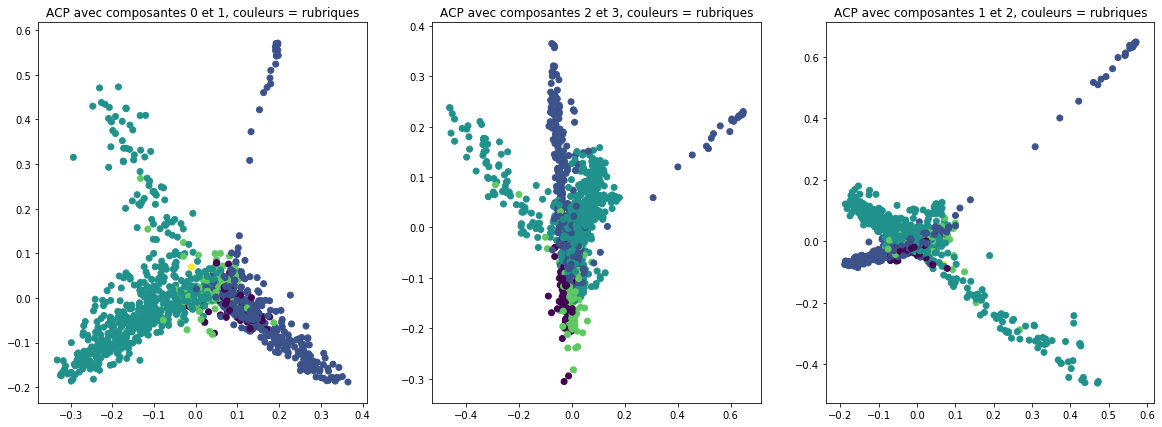

In [7]:
# reduce the features to 2D
from sklearn.decomposition import PCA

# Avec 4 principaux
random_state = 0
pca = PCA(n_components=4, random_state=random_state)
reduced_features_tfidf = pca.fit_transform(tfidf.toarray())
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features_tfidf[:,0], reduced_features_tfidf[:,1], c=rubint)
axes[0].set_title("ACP avec composantes {} et {}, couleurs = rubriques".format(0,1))
axes[1].scatter(reduced_features_tfidf[:,2], reduced_features_tfidf[:,3], c=rubint)
axes[1].set_title("ACP avec composantes {} et {}, couleurs = rubriques".format(2,3))
axes[2].scatter(reduced_features_tfidf[:,1], reduced_features_tfidf[:,2], c=rubint)
axes[2].set_title("ACP avec composantes {} et {}, couleurs = rubriques".format(1,2));

## B. Brut : Clustering en s'apuyant sur la matrice des tf-idf ou des occurrences directement

## B.1 k-means
Prendre un corpus de documents, vectoriser avec tf idf, kmeans dessus. 
* From https://sanjayasubedi.com.np/nlp/nlp-with-python-document-clustering/
* Voir https://scikit-learn.org/stable/modules/clustering.html pour clustering on python

### B.1.1 Calcul du k-means

In [8]:
from sklearn.cluster import MiniBatchKMeans
random_state = 0
kmeans_tfidf = MiniBatchKMeans(n_clusters=5, random_state=random_state)
kmeans_tfidf.fit(tfidf);
kmeans_tfidf_clusters = kmeans_tfidf.predict(tfidf)

### B.1.2 Calcul de l'ACP et affichage

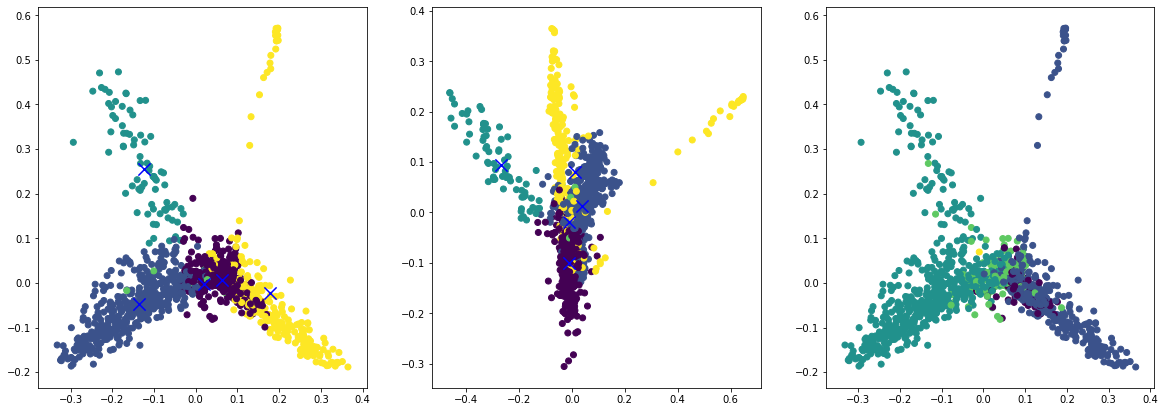

In [9]:
reduced_cluster_centers_tfidf = pca.transform(kmeans_tfidf.cluster_centers_)
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features_tfidf[:,0], reduced_features_tfidf[:,1], c=kmeans_tfidf_clusters)
axes[0].scatter(reduced_cluster_centers_tfidf[:, 0], reduced_cluster_centers_tfidf[:,1], marker='x', s=150, c='b')
axes[1].scatter(reduced_features_tfidf[:,2], reduced_features_tfidf[:,3], c=kmeans_tfidf.predict(tfidf))
axes[1].scatter(reduced_cluster_centers_tfidf[:, 2], reduced_cluster_centers_tfidf[:,3], marker='x', s=150, c='b')
axes[2].scatter(reduced_features_tfidf[:,0], reduced_features_tfidf[:,1], c=rubint)

## B.2 Ward HAC
https://chrisalbon.com/machine_learning/clustering/agglomerative_clustering/

### B.2.1 Clustering hac

In [10]:
# Create meanshift object
from sklearn.cluster import AgglomerativeClustering
aggc_tfidf = AgglomerativeClustering(linkage='complete', 
                              affinity='cosine', 
                              n_clusters=5)

# Train model
aggc_tfidf = aggc_tfidf.fit(tfidf.toarray())
aggc_tfidf_clusters = aggc_tfidf.labels_

### B.2.2 ACP et affichage

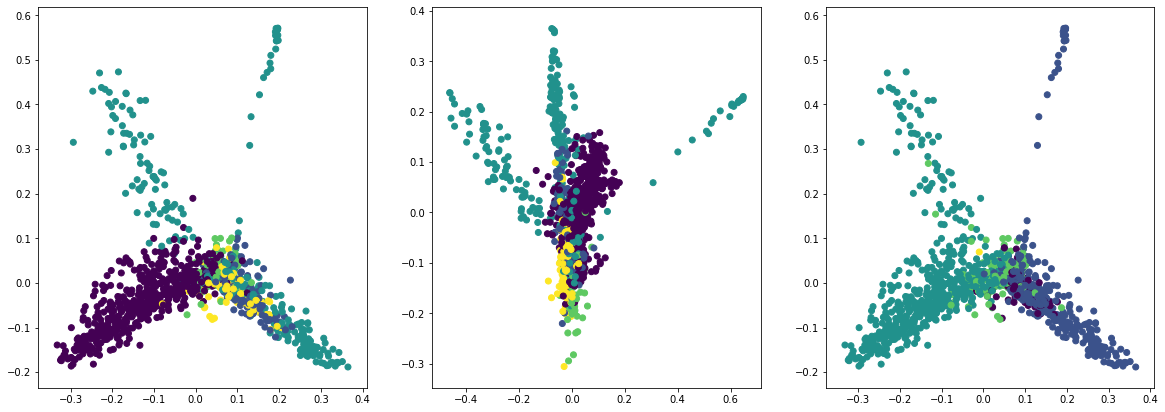

In [11]:
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features_tfidf[:,0], reduced_features_tfidf[:,1], c=aggc_tfidf_clusters)
axes[1].scatter(reduced_features_tfidf[:,2], reduced_features_tfidf[:,3], c=aggc_tfidf_clusters)
axes[2].scatter(reduced_features_tfidf[:,0], reduced_features_tfidf[:,1], c=rubint)

### B.2.Résultats, questions et suggestions
* Euclidian et complete : même résultat que k-means, assez agréable à la vue
* Euclidean et single, 5 : très bof quelques points différents au centre mais reste du meme cluster, pour dimensions 1, 2, 3 et 4
* Euclidean et ward, 5 : pas mal 
* Cosine : single et average, 5 et 20 très bof comme euclidean et single. Complete mieux pour 5 et 20 mais reste étrange (plusieurs branches de même couleur et chaos au milieu)

In [12]:
# Dendogramme associé https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html?highlight=linkage#scipy.cluster.hierarchy.linkage
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(tfidf.toarray(),metric='cosine',method = 'single');

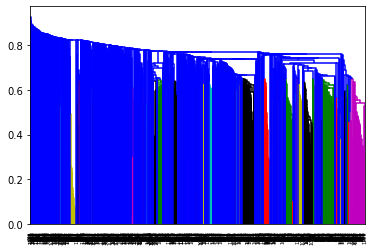

In [13]:
dendrogram(Z,p=1000,truncate_mode = 'level');

### B.2. Remarques
* Dendogramme toujours illisible en troncaté car les points arrrivent petit à petit

# B.3 X-Means
* Article original : https://www.cs.cmu.edu/~dpelleg/download/xmeans.pdf 
* pyclustering : https://pyclustering.github.io/docs/0.9.3/html/dd/db4/classpyclustering_1_1cluster_1_1xmeans_1_1xmeans.html

In [14]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster import cluster_visualizer

amount_initial_centers = 20
initial_centers = kmeans_plusplus_initializer(tfidf.toarray(), amount_initial_centers).initialize()

xmeans_instance = xmeans(tfidf.toarray(), initial_centers, 50)
xmeans_instance.process()

clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

# Print total sum of metric errors
# print("Total WCE:", xmeans_instance.get_total_wce())
print("Nb clusters:",len(clusters))

Nb clusters: 20


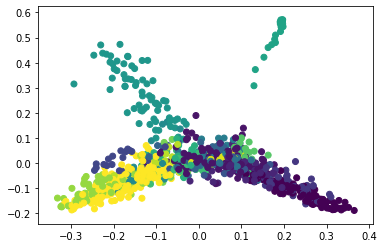

In [15]:
xmeans_clusters = pd.Series({j : i for i,m in enumerate(clusters) for j in m}).sort_index().values
plt.scatter(reduced_features_tfidf[:,0], reduced_features_tfidf[:,1], c=xmeans_clusters)
# plt.scatter(reduced_cluster_centers_tfidf[:, 0], reduced_cluster_centers_tfidf[:,1], marker='x', s=150, c='b') pas le bon reduced centers

### B.3.résultats, questions et suggestions
* Reste sur le nombre de custers minimal (5,20)
* Tester X-means sur les autres machins de vecteurs

# C. Clusetring avec décompositions de matrices
## C.3 Ananlyse Sémantique Latente LSA

### C.3.1 Décomposition en valeurs singulières

In [16]:
from sklearn.decomposition import TruncatedSVD

dim_lsa = 10 # Pas bon du tout, tenter de voir les meilleures valeurs singulières
svd_model = TruncatedSVD(n_components=dim_lsa, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(tfidf.T)
lsa_doc_vectors = svd_model.fit_transform(tfidf)

### C.3.2 Affichage des topics repérés

In [17]:
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(tfidf_feature_names, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ",end= ' ')
    for t in sorted_terms:
        print(t[0],end=' ')
    print('')

Topic 0:  maladie santé charge prise cancer patient pouvoir 
Topic 1:  service carte ant gris titre usager préfecture 
Topic 2:  cancer école enfant euro million pédiatrique compte 
Topic 3:  école compte administration million euro impayer maladie 
Topic 4:  social français étranger sécurité régime cotisation fraude 
Topic 5:  lyme tique test dépistage diagnostic protocole plan 
Topic 6:  alzheimer plan maladie enfant financement million pmnd 
Topic 7:  diabète diabétique métier alzheimer type accès atteindre 
Topic 8:  français étranger france diabète consulaire diabétique permettre 
Topic 9:  fibromyalgie alzheimer dépistage colorectal france femme trouble 


### C.3.3 Clustering et affichage (umap et acp)

In [18]:
# K-means
k_kmeans_lsa = 10
kmeans_lsa = MiniBatchKMeans(n_clusters=k_kmeans_lsa, random_state=random_state)
kmeans_lsa.fit(lsa_doc_vectors);

In [19]:
# UMAP https://umap-learn.readthedocs.io/en/latest/
from umap import UMAP
embedding = UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(lsa_doc_vectors)

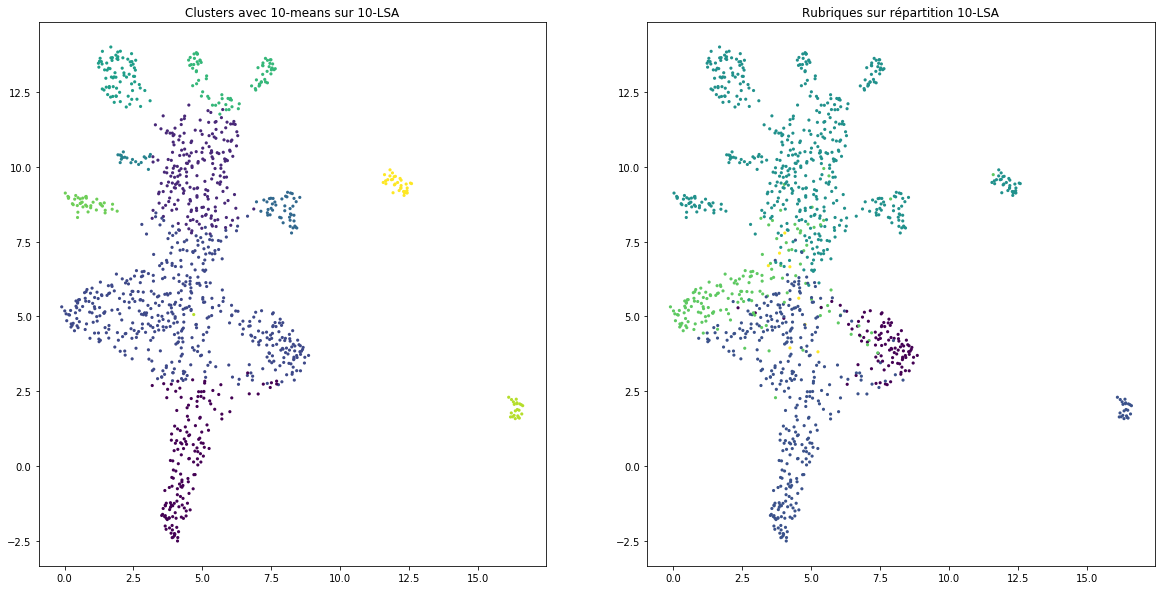

In [20]:
fig,axes = plt.subplots(1,2,figsize=(20,10))
axes[0].scatter(embedding[:, 0], embedding[:, 1], 
    c = kmeans_lsa.predict(lsa_doc_vectors),
    s = 10, # size
    edgecolor='none')
axes[0].set_title("Clusters avec {}-means sur {}-LSA".format(k_kmeans_lsa,dim_lsa));
axes[1].scatter(embedding[:, 0], embedding[:, 1], 
    c = rubint,
    s = 10, # size
    edgecolor='none')
axes[1].set_title("Rubriques sur répartition {}-LSA".format(dim_lsa));

In [21]:
# ACP
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
reduced_features_lsa = pca.fit_transform(lsa_doc_vectors)

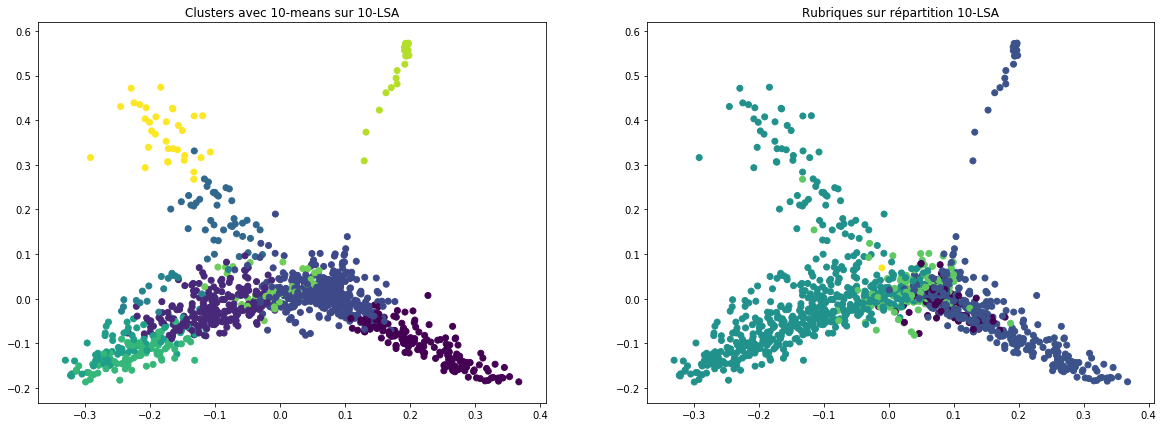

In [22]:
fig, axes = plt.subplots(1,2,figsize = (20,7))
axes[0].scatter(reduced_features_lsa[:,0], reduced_features_lsa[:,1], c=kmeans_lsa.predict(lsa_doc_vectors))
axes[1].scatter(reduced_features_lsa[:,0], reduced_features_lsa[:,1], c=rubint)
axes[0].set_title("Clusters avec {}-means sur {}-LSA".format(k_kmeans_lsa,dim_lsa));
axes[1].set_title("Rubriques sur répartition {}-LSA".format(dim_lsa));

## C.4 Allocation de Dirichlet Latente et Factorisation de Matrices non-Négatives
https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
### C.4.1 Topic modelling avec nmf et lda

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic {}".format(topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
no_features = len(corpus)

n_topics_nmf = 10
n_topics_lda = 10

# Run NMF
nmf_topics = NMF(n_components=n_topics_nmf, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda_topics = LatentDirichletAllocation(n_components=n_topics_lda, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
display_topics(nmf_topics, tfidf_feature_names, no_top_words)
display_topics(lda_topics, tf_feature_names, no_top_words)

In [ ]:
# LDA for doc vectors
lda_doc_model = LatentDirichletAllocation(n_components=n_topics_lda, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf.T)
lda_doc_vectors = lda_doc_model.components_.T

In [ ]:
# NMF for doc vectors
nmf_doc_model = NMF(n_components=n_topics_nmf, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf.T)
nmf_doc_vectors = nmf_doc_model.components_.T

### C.4.2 Clustering et affichage

In [ ]:
# GENSIM, résultat différent
# Fabrication du modèle LDA à partir des occurences des mots
# from gensim import corpora, models, similarities 
# n_topics_lda = 5
# final_doc = corpus.apply(lambda x : x.split(' '))
# dictionary = corpora.Dictionary(final_doc)

# DT_matrix = [dictionary.doc2bow(doc) for doc in final_doc]
# %time lda = models.LdaModel(DT_matrix,id2word=dictionary,num_topics=n_topics_lda)

In [ ]:
# Convertion en vecteur de sujets par document
# def to_vec(bow,k):
#     vec = np.zeros(k)
#     for i,v in bow:
#         vec[i] = v
#     return vec

# lda_gensim_doc_values = np.array([to_vec(lda.get_document_topics(DT_matrix[i]),n_topics_lda) for i in range(len(corpus))])

In [ ]:
# K-means
k_kmeans_lda = 10
kmeans_lda = MiniBatchKMeans(n_clusters=k_kmeans_lda, random_state=random_state)
kmeans_lda.fit(lda_doc_vectors);

In [ ]:
# ACP
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
reduced_features_lda = pca.fit_transform(lda_doc_vectors)

In [ ]:
# Clusering
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features_lda[:,0], reduced_features_lda[:,1], c=kmeans_lda.predict(lda_doc_vectors))
axes[1].scatter(reduced_features_lda[:,0], reduced_features_lda[:,1], c=rubint)
axes[2].scatter(reduced_features_lda[:,0], reduced_features_lda[:,1], c=groupint)
axes[0].set_title("Clusters avec {}-means sur {}-LDA".format(k_kmeans_lda,n_topics_lda));
axes[1].set_title("Rubriques sur répartition {}-LDA".format(n_topics_lda));

In [ ]:
from umap import UMAP
embedding = UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(lda_doc_vectors)

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(20,10))
axes[0].scatter(embedding[:, 0], embedding[:, 1], 
    c = kmeans_lda.predict(lda_doc_vectors),
    s = 10, # size
    edgecolor='none')
axes[1].scatter(embedding[:, 0], embedding[:, 1], 
    c = rubint,
    s = 10, # size
    edgecolor='none')
axes[0].set_title("Clusters avec {}-means sur {}-LSA".format(k_kmeans_lda,n_topics_lda));
axes[1].set_title("Rubriques sur répartition {}-LSA".format(n_topics_lda));

# D Distances entre députés

In [ ]:
# Fonction calculant les distances entre lettres
# from scipy.spatial import distance_matrix
from scipy.spatial import distance


# def matrix_distances(docs_vec,maxd = 100):
#     """ docs_vec : les vecteurs de chaque document
#         maxd : nombre maximal de documents dans la matrice
#         retourne la matrice des distances 
#     """
#     return np.array([[dist(docs_vec[i],docs_vec[j]) for i in range(maxd)] for j in range(maxd)])
                    
# # Ne sert plus
# def matrix_index(p,n):
#     """Return the index of pos p in a n*n matrix"""
#     return np.array([p//n,p%n]).T

def pair_indexes(n):
    n = n - 1
    a,b = 0,1
    l = []
    while a < n :
        l.append((a,b))
        if b < n :
            b = b + 1
        else :
            a = a + 1
            b = a + 1
    return np.array(l)

# def dist(veca,vecb):
#     return distance.cosine(veca,vecb)

# def pair_distances(docs_vec,maxd = 100):
#     """
#     retourne les paires de docments avec leur distances correspondances"""
#     return pd.DataFrame([(i,j,dist(docs_vec[i],docs_vec[j])) for i in range(maxd) for j in range(i)],columns = ['a','b','val']).sort_values(by = 'val').reset_index(drop = True)

# def compare_corpus(padi,corpus,idx):
#     """Montre les deux documents du corpus correspondant à l'indice demandé"""
#     a,b,v = padi.loc[idx,]
#     print("Lien {} de valeur {} :".format(idx,v))
#     print(corpus.values[[int(a),int(b)]])

In [ ]:
# Import pdist
from scipy.spatial.distance import pdist, squareform

### Term Frequency

In [ ]:
# Clacul avec les features du tf
vc_tf = tf.toarray()
dists_tf = pdist(vc_tf,'cosine')

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
axes[0].plot(np.sort(dists_tf))
sns.distplot(dists_tf, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[1])
# print(corpus.values[(pair_indexes(len(vc_tf))[np.argsort(dists_tf)])[0]])
print("Mean = {}, Std = {}".format(dists_tf.mean(),dists_tf.std()))

### TF - IDF

In [ ]:
# Clacul avec les features du tfidf
vc_tfidf = tfidf.toarray()
dists_tfidf = pdist(vc_tfidf,'cosine')

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
axes[0].plot(np.sort(dists_tfidf))
sns.distplot(dists_tfidf, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[1])

# print(corpus.values[(pair_indexes(len(vc_tfidf))[np.argsort(dists_tfidf)])[0]])
print("Mean = {}, Std = {}".format(dists_tfidf.mean(),dists_tfidf.std()))

### PCA TF - IDF

In [ ]:
# Clacul avec les reduced features du tfidf
# PCA
k_reduce = 10
reduced_tfidf = pca.fit_transform(tfidf.toarray())
pca = PCA(n_components=k_reduce, random_state=random_state)

# Calcul des distances
vc_pca = reduced_tfidf
dists_pca = pdist(vc_pca,'cosine')

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
axes[0].plot(np.sort(dists_pca))
sns.distplot(dists_pca, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[1])
# corpus.values[(pair_indexes(len(vc_pca))[np.argsort(dists_pca)])[0]]
print("Mean = {}, Std = {}".format(dists_pca.mean(),dists_pca.std()))

### LSA

In [ ]:
# Clacul avec les le LSA
vc_lsa = lsa_doc_vectors
dists_lsa = pdist(vc_lsa,'cosine')

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
axes[0].plot(np.sort(dists_lsa))
sns.distplot(dists_lsa, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[1])
corpus.values[(pair_indexes(len(vc_lsa))[np.argsort(dists_lsa)])[0]]
print("Mean = {}, Std = {}".format(dists_lsa.mean(),dists_lsa.std()))

In [ ]:
# Clacul avec le nmf
vc_nmf = nmf_doc_vectors
dists_nmf = pdist(vc_nmf,'cosine')

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
axes[0].plot(np.sort(dists_nmf))
sns.distplot(dists_nmf, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[1])
corpus.values[(pair_indexes(len(vc_nmf))[np.argsort(dists_nmf)])[0]]
print("Mean = {}, Std = {}".format(dists_nmf.mean(),dists_nmf.std()))

### LDA

In [ ]:
# Clacul avec le lda
vc_lda = lda_doc_vectors
dists_lda = pdist(vc_lda,'cosine')

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
axes[0].plot(np.sort(dists_lda))
sns.distplot(dists_lda, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[1])
corpus.values[(pair_indexes(len(vc_lda))[np.argsort(dists_lda)])[0]]
print("Mean = {}, Std = {}".format(dists_lda.mean(),dists_lda.std()))

# E. Tests avec des textes choisis

In [ ]:
# Choix des documents
dfhi = dfh.reset_index(drop=True)
l_lyme = dfhi[dfhi.titre.str.contains('lyme')&dfhi.titre.str.contains('lutte')&dfhi.titre.str.contains('maladie')].head(3)
l_front = dfhi[dfhi.titre.str.contains('frontalier')&dfhi.titre.str.contains('travailleur')]
l_ha = dfhi.loc[[4]]
lettres_choisies= pd.concat([l_lyme,l_front,l_ha])

### TF

In [ ]:
# Brut tf
docs_choisis_tf = tf.toarray()[lettres_choisies.index]
matrix_choisie_tf = squareform(pdist(docs_choisis_tf,'cosine'))

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_tf) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_tf,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

### TF -IDF

In [ ]:
# Brut tfidf
docs_choisis_tfidf = tfidf.toarray()[lettres_choisies.index]
matrix_choisie_tfidf = squareform(pdist(docs_choisis_tfidf,'cosine'))

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_tfidf) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_tfidf,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

### PCA TF - IDF

In [ ]:
# Brut tfidf
k_reduce = 10
reduced_tfidf = pca.fit_transform(tfidf.toarray())
pca = PCA(n_components=k_reduce, random_state=random_state)
docs_choisis_pca_tfidf = reduced_tfidf[lettres_choisies.index]
matrix_choisie_pca_tfidf = squareform(pdist(docs_choisis_pca_tfidf,'cosine'))

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_tfidf) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_pca_tfidf,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

### LSA

In [ ]:
# LSA
docs_choisis_lsa = lsa_doc_vectors[lettres_choisies.index]
matrix_choisie_lsa = squareform(pdist(docs_choisis_lsa,'cosine'))

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_lsa) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_lsa,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

### LDA

In [ ]:
# LDA
docs_choisis_lda = lda_doc_vectors[lettres_choisies.index]
matrix_choisie_lda = squareform(pdist(docs_choisis_lda,'cosine'))

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_lda) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_lda,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

## NMF

In [ ]:
# nmf
docs_choisis_nmf = nmf_doc_vectors[lettres_choisies.index]
matrix_choisie_nmf = squareform(pdist(docs_choisis_nmf,'cosine'))

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_nmf) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_nmf,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

## F. Trouver les amis d'une lettre

In [ ]:
l_lyme.head(1)
matrix = squareform(dists_lda)

sns.distplot(matrix[19], hist=True, kde=True, 
     bins=int(180/5), color = 'darkblue', 
     hist_kws={'edgecolor':'black'},
     kde_kws={'linewidth': 4})

In [ ]:
r = 5
c = 5
trucs = sample(range(len(corpus)),r*c)
fig,axes = plt.subplots(r,c,figsize=(15,15))
for i in range(c):
    for j in range(r):
        sns.distplot(matrix[trucs[i*c+j]],ax = axes[i,j])

# F. Tests d'évalutation des clustering

In [ ]:
# Choix des données
doc_vec= lsa_doc_vectors
doc_vec.shape

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=5, random_state=random_state)
kmeans.fit(doc_vec);
kmeans_clusters = kmeans.predict(doc_vec)
kmeans.inertia_
calinski_harabasz_score(doc_vec,kmeans_clusters)

## F.2 Pour trouver le meilleur k
Voir https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

In [ ]:
# Exécution des k-means
possible_k = range(1,36,1)
all_clusters = np.empty((len(possible_k),len(doc_vec)))
inerties = np.empty((len(possible_k,)))
calinski = np.empty((len(possible_k,)))
bouldin = np.empty((len(possible_k,)))
for i,k in enumerate(possible_k):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(doc_vec);
    kmeans_clusters = kmeans.predict(doc_vec)
    all_clusters[i] = kmeans_clusters
    inerties[i] = kmeans.inertia_
    if k > 1:
        calinski[i] = calinski_harabasz_score(doc_vec,kmeans_clusters)
        bouldin[i] = davies_bouldin_score(doc_vec,kmeans_clusters)

### F.2.2 Critères

In [ ]:
fig, axes = plt.subplots(1,3,figsize = (18,7))
axes[0].plot(possible_k,inerties);
axes[0].set_title('intertie')
axes[1].plot(possible_k,calinski);
axes[1].set_title('calinski')
axes[2].plot(possible_k,bouldin);
axes[2].set_title('bouldin')